In [1]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import cv2
import math
import random 

In [2]:
global img1
global img2
global img3
img1 = cv2.imread("circle.jpg")
img2 = cv2.imread('concentric_circles.jpg')
img3 = cv2.imread("parliament_clock.jpg")
global h1, w1, c1
h1, w1, c1 = img1.shape
global h2, w2, c2
h2, w2, c2 = img2.shape
global h3, w3, c3
h3, w3, c3 = img3.shape

Text(0.5, 1.0, 'Edge Image')

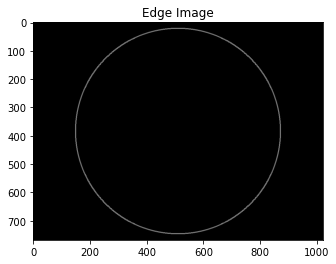

In [3]:
canny_output = cv2.Canny(img1, 100, 200)
plt.imshow(cv2.cvtColor(canny_output,cv2.COLOR_BGR2RGB))
plt.title("Edge Image")

In [4]:
def RadiusGetter(point1, point2):
    return int(math.sqrt(np.square(point1[0]-point2[0]) + np.square(point1[1]-point2[1])))

In [5]:
def Canny_edge(mini, maxi, img):
    Gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    smooth = cv2.GaussianBlur(Gray, (5,5), cv2.BORDER_DEFAULT)
    cannyRes = cv2.Canny(smooth, mini, maxi)   
    return cannyRes

In [6]:
global white1
white1 = []
cannyRes1 = Canny_edge(50, 300, img1)
for i in range(h1):
    for j in range(w1):
        if (cannyRes1[i,j]==255):
            white1.append([i,j])

In [7]:
global white2
white2 = []
cannyRes2 = Canny_edge(50, 300, img2)
for i in range(h2):
    for j in range(w2):
        if (cannyRes2[i,j]==255):
            white2.append([i,j])

In [8]:
global white3
white3 = []
cannyRes3 = Canny_edge(50, 300, img3)
for i in range(h3):
    for j in range(w3):
        if (cannyRes1[i,j]==255):
            white3.append([i,j])

In [9]:
#randomly select 3 point from edge
def point_generator(k, cannyRes, white):
    point = []
    point = random.sample(white,k)
    checkSlope = (point[2][1] - point[0][1])*(point[1][0] - point[0][0]) - (point[1][1]-point[0][1])*(point[2][0]-point[0][0])
    checkZero = (point[0][0] - point[1][0]) and (point[0][0] - point[2][0])
    checkYpos = (point[0][1] - point[1][1]) and (point[0][1] - point[2][1])
    if(checkSlope and checkZero and checkYpos):
        return point
    else:
        return point_generator(k, cannyRes, white)                                                                                       

In [10]:
def PerpendicularBisector(cannyRes, white): 
        points = point_generator(3, cannyRes, white)
        x1 = points[0][0]
        y1 = points[0][1]
        x2 = points[1][0]
        y2 = points[1][1]
        x3 = points[2][0]
        y3 = points[2][1]
        mp1 = [(x1+x2)/2, (y1+y2)/2]
        mp2 = [(x1+x3)/2, (y1+y3)/2]
        circle = [] #circle will store center and radius
        m1 = (y1-y2)/(x1-x2)
        m2 = (y1-y3)/(x1-x3)
        ps1 = -(1/m1)
        ps2 = -(1/m2)
        a = np.array([[ps1,-1],[ps2,-1]])
        b = np.array([ps1*mp1[0]-mp1[1],ps2*mp2[0]-mp2[1]])
        center = np.linalg.solve(a,b)
        centerX = int(center[1])
        centerY = int(center[0])
        if(centerX>0 and centerY>0):
            center = [centerX,centerY]
                #print(center)                
            Radius = RadiusGetter(center, points[0])
            circle.append(center)
            circle.append(Radius)
        else:
            return PerpendicularBisector(cannyRes, white)
        
        return circle

Edge debugging

 Iter 9circle [[511, 384], 317] 

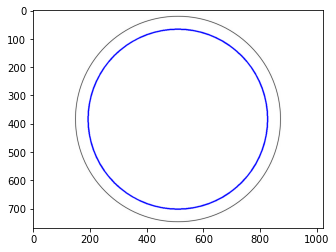

In [11]:
temp = cv2.imread("circle.jpg")
tempEdge = Canny_edge(50, 300, temp)
for i in range(10):
    circleTemp = PerpendicularBisector(tempEdge, white1)
    print("\r Iter "+str(i)+"circle",circleTemp,end = ' ')
circle = cv2.circle(temp,tuple(circleTemp[0]),circleTemp[1],(255,0,0),4)

# plt.subplot(2,1,1)
plt.imshow(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))

# plt.subplot(2,1,2)
# plt.imshow(cv2.cvtColor(tempEdge,cv2.COLOR_BGR2RGB))

In [12]:
def Ransac(N, img, h, w, white):
    I = 0
    C = -1
    (best_x, best_y, best_r) = (0,0,0)
    points = []
    while(I < N):
        k = 0     
        compareCircle = np.zeros((h,w), dtype=np.uint8)
        circle = PerpendicularBisector(img, white)
        circle3 = cv2.circle(compareCircle,tuple(circle[0]),circle[1],(255,255,255), 5)
       
        for i in range(h):
            for j in range(w):
                if img[i,j] == 255 and circle3[i,j] ==255:
                    k = k + 1
                    
        if (k > C):
            (best_x, best_y, best_r) = (circle[0][0], circle[0][1], circle[1]) 
            C = k
        I = I + 1
        bestCircle =  (best_x, best_y, best_r) 
        print("Iteration = "+str(I)+"   \tBest: "+str(bestCircle))   
    return (best_x, best_y, best_r)       

In [13]:
def Postprocessing(img, ref_center, white):
        points = point_generator(3, img, white)
        x1 = points[0][0]
        y1 = points[0][1]
        x2 = points[1][0]
        y2 = points[1][1]
        x3 = points[2][0]
        y3 = points[2][1]
        mp1 = [(x1+x2)/2, (y1+y2)/2]
        mp2 = [(x1+x3)/2, (y1+y3)/2]
        circle = [] #circle will store center and radius
        m1 = (y1-y2)/(x1-x2)
        m2 = (y1-y3)/(x1-x3)
        ps1 = -(1/m1)
        ps2 = -(1/m2)
        a = np.array([[ps1,-1],[ps2,-1]])
        b = np.array([ps1*mp1[0]-mp1[1],ps2*mp2[0]-mp2[1]])
        center = np.linalg.solve(a,b)
        centerX = int(center[1])
        centerY = int(center[0])
        if(centerX>0 and centerY>0) and (abs(centerX - ref_center[0]) <=50 and abs(centerY - ref_center[1]) <=50):
            center = [centerX,centerY]
                #print(center)                
            Radius = RadiusGetter(center, points[0])
            circle.append(center)
            circle.append(Radius)                           
        else:
            return Postprocessing(img, ref_center, white)
#         abs(centerpoint[0]-ref_center[0])<=50 and abs(centerpoint[1]-ref_center[1])<=50:
        
        return circle

In [14]:
def circle_debugging(img, circle):
    img_output = cv2.circle(img,tuple(circle[0]), circle[1], (255,0,0), 5)
    return img_output

In [15]:
def main(img, N, white, h, w):
    cannyRes = Canny_edge(50,300,img)
    best_circle = Ransac(N, cannyRes, h, w, white)
    cv2.circle(img,(best_circle[0],best_circle[1]),best_circle[2],(0,0,255),5)
    compareImg = np.zeros((h,w), dtype=np.uint8)
    cv2.circle(compareImg,(best_circle[0],best_circle[1]),best_circle[2],(255,255,255),5)
    best_circle = Postprocessing(img, best_circle, white)
    print(best_circle)
    cv2.circle(img,(best_circle[0][0],best_circle[0][1]),best_circle[1],(0,255,0),5)

    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 2

    fig.add_subplot(rows, columns, 1) 
    plt.imshow(cv2.cvtColor(cannyRes,cv2.COLOR_BGR2RGB))
    plt.title("Canny Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title("RANSAC circle")

Iteration = 1   	Best: (511, 384, 323)
Iteration = 2   	Best: (511, 384, 323)
Iteration = 3   	Best: (511, 384, 323)
Iteration = 4   	Best: (511, 384, 323)
Iteration = 5   	Best: (511, 384, 323)
Iteration = 6   	Best: (511, 384, 323)
Iteration = 7   	Best: (511, 384, 323)
Iteration = 8   	Best: (511, 384, 323)
Iteration = 9   	Best: (511, 384, 323)
Iteration = 10   	Best: (511, 384, 323)
[[510, 385], 245]


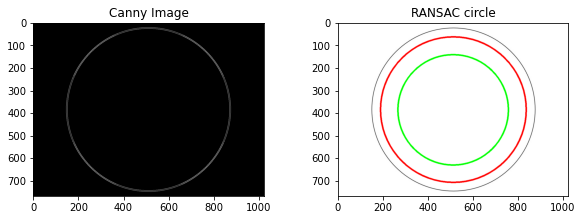

In [16]:
main(img1, 10, white1, h1, w1)

Iteration = 1   	Best: (128, 112, 88)
Iteration = 2   	Best: (128, 112, 88)
Iteration = 3   	Best: (128, 112, 88)
Iteration = 4   	Best: (128, 112, 88)
Iteration = 5   	Best: (128, 112, 88)
Iteration = 6   	Best: (128, 112, 88)
Iteration = 7   	Best: (128, 112, 88)
Iteration = 8   	Best: (128, 112, 88)
Iteration = 9   	Best: (150, 151, 141)
Iteration = 10   	Best: (150, 151, 141)
[[181, 163], 69]


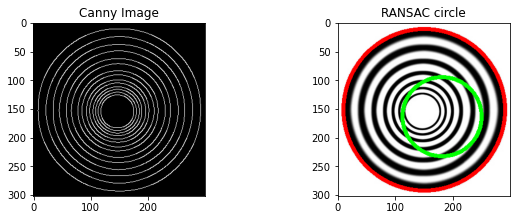

In [17]:
main(img2, 10, white2, h2, w2)

Iteration = 1   	Best: (944, 787, 984)
Iteration = 2   	Best: (944, 787, 984)
Iteration = 3   	Best: (944, 787, 984)
Iteration = 4   	Best: (944, 787, 984)
Iteration = 5   	Best: (343, 225, 240)
Iteration = 6   	Best: (343, 225, 240)
Iteration = 7   	Best: (343, 225, 240)
Iteration = 8   	Best: (343, 225, 240)
Iteration = 9   	Best: (343, 225, 240)
Iteration = 10   	Best: (343, 225, 240)
[[376, 248], 285]


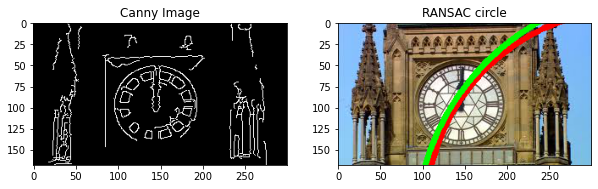

In [18]:
main(img3, 10, white3, h3, w3)